In [2]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import normalize, minmax_scale
from scipy.stats import pearsonr, spearmanr, f_oneway, norm
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/sibcb1/chenluonanlab8/caideyu/CauTrigger_new/')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import scanpy as sc
import torch
import torch.nn as nn
torch.cuda.set_device(0)
import pybedtools
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score
)
from scipy.sparse import load_npz
from scipy.sparse import coo_matrix

from CauTrigger.utils import set_seed, select_features
from CauTrigger.model import CauTrigger3L, CauTrigger2L, CauTrigger1L
set_seed(42)

In [4]:
data_dir = '/sibcb1/chenluonanlab8/caideyu/CauTrigger_new/BenchmarkGRN/PBMC/data/'
output_dir = '/sibcb1/chenluonanlab8/caideyu/CauTrigger_new/BenchmarkGRN/PBMC/output/'
os.makedirs(output_dir, exist_ok=True)

In [12]:
TF = pd.read_csv(os.path.join(data_dir, 'filtered_TF_pseudobulk.csv'), index_col=0).T  # 343 metacell x 154 TF
RE = pd.read_csv(os.path.join(data_dir, 'filtered_RE_pseudobulk.csv'), index_col=0).T  # 343 metacell x 22207 RE
TG = pd.read_csv(os.path.join(data_dir, 'filtered_TG_pseudobulk.csv'), index_col=0).T  # 343 metacell x 5378 TG

In [13]:
adata_RNA_all = sc.read_h5ad(os.path.join(data_dir, 'adata_RNA.h5ad'))
adata_ATAC_all = sc.read_h5ad(os.path.join(data_dir, 'adata_ATAC.h5ad'))

In [14]:
labels = pd.read_csv(os.path.join(data_dir, 'PBMC_label.txt'), sep='\t')

In [15]:
labels_indexed = labels.set_index(labels.columns[0])
aligned_values = labels_indexed.loc[TF.index, labels.columns[1]].values  # 这是metacell每个的celltype
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
numeric_values = label_encoder.fit_transform(aligned_values)  # 这是metacell每个的数字标签

In [16]:
label_map = pd.DataFrame({
    "celltype": label_encoder.classes_,
    "label": np.arange(len(label_encoder.classes_))
})
celltypes = label_encoder.classes_

In [19]:
linger_used_table = pd.read_csv(os.path.join(data_dir, 'CistromeDB_linger_used/linger用的PBMC的金标准.csv'))  # 20
linger_used_table = linger_used_table.loc[np.isin(linger_used_table['Transcription factor'], TF.columns), :]  # 16

In [9]:
# RE-TG interaction matrix
sparse_matrix = load_npz(os.path.join(data_dir, "TG_RE_interaction_matrix.npz"))  # 5378 x 20573
sparse_matrix_index = pd.read_csv(os.path.join(data_dir, "TG_RE_interaction_matrix_rows.txt")).values.flatten()
sparse_matrix_column = pd.read_csv(os.path.join(data_dir, "TG_RE_interaction_matrix_cols.txt")).values.flatten()

## CauTrigger-321

In [9]:
adata1 = sc.AnnData(TG)
adata1.var_names = np.array(TG.columns)
adata1.obs_names = np.array(TG.index)
# adata1.obsm['X_down'] = np.array(TG)
adata1.obs["labels"] = numeric_values
adata1.obs["celltype"] = aligned_values

model321_1 = CauTrigger1L(
    adata1,
    n_latent=10,
    n_hidden=128,
    n_state=len(np.unique(aligned_values)),
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    dropout_rate_dpd=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=True,
    dpd_linear=False,
    # update_down_weight=True,
    init_thresh=0.00,
    attention=False,
    att_mean=False,
)

In [10]:
model321_1.train(max_epochs=300, batch_size=64, stage_training=True, weight_scheme="pbmc")

training: 100%|██████████| 300/300 [01:19<00:00,  3.75it/s]


In [19]:
weight_df_weight1 = model321_1.get_up_feature_weights(normalize=True, method="Grad", sort_by_weight=False)
causal_factors_layer1_indices = np.argsort(weight_df_weight1[0]['weight'])[-3000:][::-1]

adata2 = sc.AnnData(RE)
adata2.var_names = np.array(RE.columns)
adata2.obs_names = np.array(RE.index)
adata2.obs["labels"] = numeric_values
adata2.obs["celltype"] = aligned_values
adata2.obsm['X_down'] = adata1.X[:, causal_factors_layer1_indices]
adata2.uns['TG_names'] = adata1[:, causal_factors_layer1_indices].var_names.values

In [22]:
adata2.write(data_dir + 'adatatmp2.h5ad')

In [8]:
adata2 = sc.read_h5ad(data_dir + 'adatatmp2.h5ad')

In [9]:
model321_2 = CauTrigger2L(
    adata2,
    n_latent=10,
    n_hidden=128,
    n_state=len(np.unique(aligned_values)),
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    dropout_rate_dpd=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=True,
    dpd_linear=False,
    # update_down_weight=True,
    init_thresh=0.00,
    attention=False,
    att_mean=False,
)

In [10]:
model321_2.train(max_epochs=300, batch_size=32, stage_training=True, weight_scheme="pbmc")

training: 100%|██████████| 300/300 [06:04<00:00,  1.21s/it]


In [11]:
weight_df_weight2 = model321_2.get_up_feature_weights(normalize=True, method="Grad", sort_by_weight=False)
causal_factors_layer2_indices = np.argsort(weight_df_weight2[0]['weight'])[-10000:][::-1]

adata3 = sc.AnnData(TF)
adata3.var_names = np.array(TF.columns)
adata3.obs_names = np.array(TF.index)
adata3.obs["labels"] = numeric_values
adata3.obs["celltype"] = aligned_values
adata3.obsm['X_down2'] = adata2.obsm['X_down'].copy()
adata3.obsm['X_down1'] = adata2.X[:, causal_factors_layer2_indices]
adata3.uns['TG_names'] = adata2.uns['TG_names'].copy()
adata3.uns['RE_names'] = adata2[:, causal_factors_layer2_indices].var_names.values

In [39]:
adata3.write(data_dir + 'adatatmp3.h5ad')

In [8]:
adata3 = sc.read_h5ad(data_dir + 'adatatmp3.h5ad')

In [40]:
model321_3 = CauTrigger3L(
    adata3,
    n_latent=10,
    n_hidden=128,
    n_state=len(np.unique(aligned_values)),
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    dropout_rate_dpd=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=True,
    dpd_linear=False,
    # update_down_weight=True,
    init_thresh=0.00,
    attention=False,
    att_mean=False,
    decoder_down2_sparse=False,
)

In [41]:
model321_3.train(max_epochs=300, batch_size=32, stage_training=True, weight_scheme="pbmc")

training: 100%|██████████| 300/300 [11:53<00:00,  2.38s/it]


In [47]:
tf_tg_ig_dict321 = {}
for celltype in ['naive B cells', 'myeloid DC', 'classical monocytes', 'naive CD4 T cells']:
    tf_tg_ig_dict321[celltype] = model321_3.get_3to1_ig(data_dir=data_dir, celltype=celltype)

In [48]:
tf_tg_interaction_dict321 = {}
for idx, row in linger_used_table.iterrows():
    celltype = row[2]
    tfname = row[1]

    tf_tg_interaction = tf_tg_ig_dict321[celltype]
    tf_tg_interaction = tf_tg_interaction.mean(axis=0)
    tf_tg_interaction = tf_tg_interaction[np.where(TF.columns == tfname)[0][0], :]
    tf_tg_interaction_dict321[(celltype, tfname)] = tf_tg_interaction

## CellOracle

In [17]:
import celloracle as co
base_GRN = co.data.load_human_promoter_base_GRN(version='hg38_gimmemotifsv5_fpr2')
adata_co = adata_RNA_all.copy()
# sc.pp.highly_variable_genes(adata_co, n_top_genes=2000, flavor='cell_ranger')
# adata_co = adata_co[:, adata_co.var.highly_variable]
sc.tl.pca(adata_co)
adata_co.layers['raw_count'] = adata_co.X.copy()
oracle = co.Oracle()
oracle.import_anndata_as_normalized_count(adata=adata_co, cluster_column_name="label", embedding_name="X_pca")
oracle.import_TF_data(TF_info_matrix=base_GRN)
oracle.perform_PCA()
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
n_comps = min(n_comps, 50)
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=4)
links = oracle.get_links(cluster_name_for_GRN_unit="label", alpha=10, verbose_level=10, model_method='bayesian_ridge')
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
links.get_network_score()

Loading prebuilt promoter base-GRN. Version: hg38_gimmemotifsv5_fpr2
25485 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


  0%|          | 0/14 [00:00<?, ?it/s]

Inferring GRN for CD56 (bright) NK cells...


  0%|          | 0/17933 [00:00<?, ?it/s]

Inferring GRN for CD56 (dim) NK cells...


  0%|          | 0/17933 [00:00<?, ?it/s]

Inferring GRN for MAIT T cells...


  0%|          | 0/17933 [00:00<?, ?it/s]

Inferring GRN for classical monocytes...


  0%|          | 0/17933 [00:00<?, ?it/s]

Inferring GRN for effector CD8 T cells...


  0%|          | 0/17933 [00:00<?, ?it/s]

Inferring GRN for intermediate monocytes...


  0%|          | 0/17933 [00:00<?, ?it/s]

Inferring GRN for memory B cells...


  0%|          | 0/17933 [00:00<?, ?it/s]

Inferring GRN for memory CD4 T cells...


  0%|          | 0/17933 [00:00<?, ?it/s]

Inferring GRN for myeloid DC...


  0%|          | 0/17933 [00:00<?, ?it/s]

Inferring GRN for naive B cells...


  0%|          | 0/17933 [00:00<?, ?it/s]

Inferring GRN for naive CD4 T cells...


  0%|          | 0/17933 [00:00<?, ?it/s]

Inferring GRN for naive CD8 T cells...


  0%|          | 0/17933 [00:00<?, ?it/s]

Inferring GRN for non-classical monocytes...


  0%|          | 0/17933 [00:00<?, ?it/s]

Inferring GRN for plasmacytoid DC...


  0%|          | 0/17933 [00:00<?, ?it/s]

In [ ]:
tf_tg_score_df_dict = {}

In [49]:
for idx, row in linger_used_table.iterrows():
    celltype = row[2]
    tfname = row[1]

    t = pd.read_csv(output_dir + f'linger/cell_type_specific_trans_regulatory_{celltype}.txt', index_col=0, sep='\t')  # TG x TF


    
    tf_tg_score_df_dict[(celltype, tfname)]['LINGER'] = t.loc[:, tfname]

    tf_tg_score_df_dict[(celltype, tfname)]['LINGER'] = tf_tg_score_df_dict[(celltype, tfname)]['LINGER'].fillna(0)
    

In [20]:
for idx, row in linger_used_table.iterrows():
    celltype = row[2]
    tfname = row[1]

    t = links.links_dict[celltype].loc[links.links_dict[celltype].source == tfname, ['target', 'coef_abs']]
    t.index = t.target
    t = t.iloc[:, [1]]


    
    tf_tg_score_df_dict[(celltype, tfname)]['CellOracle'] = t

    tf_tg_score_df_dict[(celltype, tfname)]['CellOracle'] = tf_tg_score_df_dict[(celltype, tfname)]['CellOracle'].fillna(0)
    

In [21]:
import pickle
with open(os.path.join(data_dir, 'dictys_res_dict.pkl'), 'rb') as f:
    dictys_res_dict = pickle.load(f)

for idx, row in linger_used_table.iterrows():
    celltype = row[2]
    tfname = row[1]

    t = dictys_res_dict[(celltype, tfname)]

    tf_tg_score_df_dict[(celltype, tfname)]['Dictys'] = t

    tf_tg_score_df_dict[(celltype, tfname)]['Dictys'] = tf_tg_score_df_dict[(celltype, tfname)]['Dictys'].fillna(0)
    

In [52]:
for idx, row in linger_used_table.iterrows():
    celltype = row[2]
    tfname = row[1]

    tf_tg_interaction321 = tf_tg_interaction_dict321[(celltype, tfname)]
    tf_tg_interaction_df2 = pd.DataFrame(tf_tg_interaction321.T, index=adata3.uns['TG_names'])
    tf_tg_interaction_df2.rename(columns={0: 'score'}, inplace=True)
    tf_tg_score_df_dict[(celltype, tfname)]['CauTrigger-321'] = tf_tg_interaction_df2
    tf_tg_score_df_dict[(celltype, tfname)]['CauTrigger-321'] = tf_tg_score_df_dict[(celltype, tfname)]['CauTrigger-321'].fillna(0)

In [23]:
tftg_f1_dict_01 ={}
tftg_f1_dict_02 ={}
tftg_f1_dict_03 ={}


for idx, row in linger_used_table.iterrows():
    celltype = row[2]
    tfname = row[1]

    for method in ['CauTrigger-321', 'Dictys', 'LINGER', 'GENIE3', 'PCC', 'CellOracle']:
          
        if method not in tftg_auroc_dict_01:
            tftg_f1_dict_01[method] = []
            tftg_f1_dict_02[method] = []
            tftg_f1_dict_03[method] = []

        threshold = tf_tg_score_df_dict[(celltype, tfname)][method].quantile(0.9)
        y_pred = (tf_tg_score_df_dict[(celltype, tfname)][method] >= threshold).astype(int)
        tftg_f1_dict_01[method].append(f1_score(tf_tg_score_df_dict[(celltype, tfname)].hit, y_pred))

        threshold = tf_tg_score_df_dict[(celltype, tfname)][method].quantile(0.85)
        y_pred = (tf_tg_score_df_dict[(celltype, tfname)][method] >= threshold).astype(int)
        tftg_f1_dict_02[method].append(f1_score(tf_tg_score_df_dict[(celltype, tfname)].hit, y_pred))

        threshold = tf_tg_score_df_dict[(celltype, tfname)][method].quantile(0.8)
        y_pred = (tf_tg_score_df_dict[(celltype, tfname)][method] >= threshold).astype(int)

In [40]:
def dict_to_long_df(metric_dict, metric_name):
    df = pd.DataFrame([
        {'Method': method, metric_name: value}
        for method, values in metric_dict.items()
        for value in values
    ])
    return df

metrics = ['10', '15', '20']

tftg_dfs = [
    dict_to_long_df(eval(f"tftg_f1_dict_0{idx+1}"), metric)
    for idx, metric in enumerate(metrics)
]

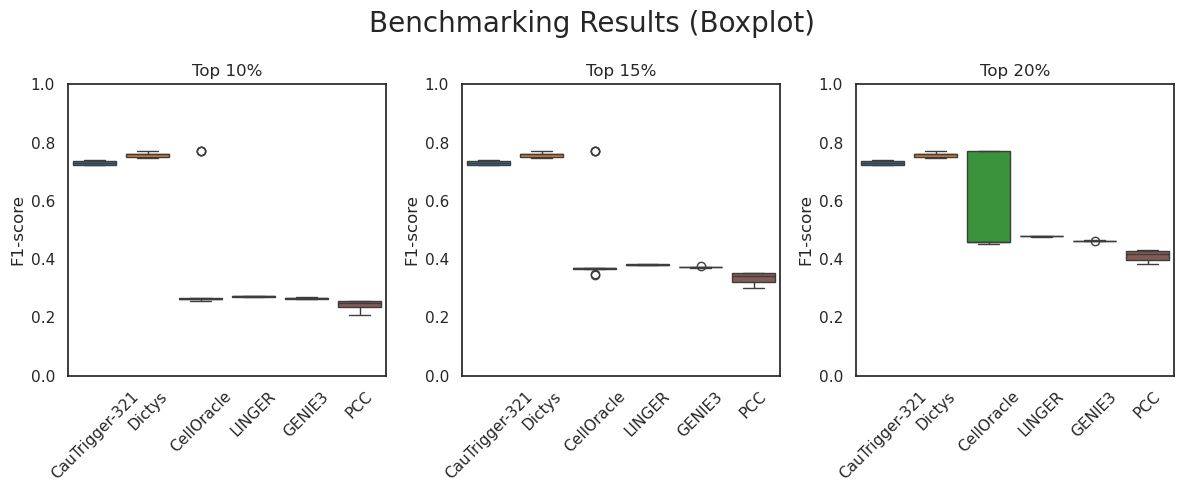

In [48]:
sns.set(style="white")
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Benchmarking Results (Boxplot)", fontsize=20)


for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.boxplot(
        data=tftg_dfs[i],
        x='Method',
        y=metric,
        ax=ax,
        palette='tab10',
        order=['CauTrigger-321', 'Dictys', 'CellOracle', 'LINGER', 'GENIE3', 'PCC']
    )
    ax.set_title(f"Top {metric}%")
    ax.set_ylim(0, 1)
    ax.set_xlabel("")
    ax.set_ylabel("F1-score")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()